In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dense, Dropout, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/augusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [2]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  Estou contente com a compra entrega rápida o ú...
1                    4  Por apenas R$1994.20,eu consegui comprar esse ...
2                    4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                    4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                    5  A entrega foi no prazo, as americanas estão de...
...                ...                                                ...
132368               5  Vale muito, estou usando no controle do Xbox e...
132369               5  Prático e barato, super indico o produto para ...
132370               4  Chegou antes do prazo previsto e corresponde a...
132371               1  Material fraco, poderia ser melhor. Ficou deve...
132372               1  Comprei esse produto, quando chegou estava com...

[132373 rows x 2 columns]>


In [3]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [4]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [5]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [6]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

In [7]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  bom chegou antes data prevista produto chegou ...
1                    5  qualidade boa produto original excelente fazer...
2                    5  atendeu totalmente expectativa material excele...
3                    4                             recebi data tudo certo
4                    1  nao recebi produto ainda nao recebi renbolco v...
...                ...                                                ...
132368               5  excelente qualidade boa economiza tempo legal ...
132369               3             potes pequenos nao gostei material bom
132370               5            correspondeu espectativas tamanho otimo
132371               1  nao especificacoes medidas possui tamanho inad...
132372               5  entregue antes prazo bem embalado codigo rastr...

[132373 rows x 2 columns]>


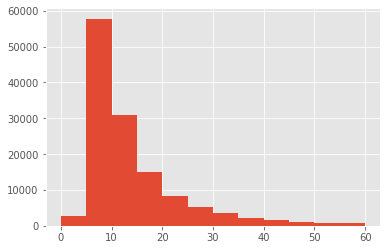

130344


In [8]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [9]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [10]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [11]:
b2wCorpus.shape

(132373, 3)

In [12]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 10].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [13]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [14]:
b2wCorpus.shape

(68406, 3)

In [15]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [16]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,0,"[7804, 7256, 902, 62, 7804, 7256, 0, 291, 2537...",10
1,0,"[9735, 304, 7804, 7256, 12783, 10545, 785, 166...",12
2,4,"[76, 4108, 11735, 29588, 4104, 3835, 457, 1494...",13
3,0,"[9735, 128, 10492, 128, 4774, 10185, 2288, 184...",14
4,0,"[902, 382, 175496, 40728, 1143, 17129, 714, 39...",30


In [17]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [18]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [19]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,0,"[7804, 7256, 902, 62, 7804, 7256, 0, 291, 2537...",10
1,0,"[9735, 304, 7804, 7256, 12783, 10545, 785, 166...",12
2,4,"[76, 4108, 11735, 29588, 4104, 3835, 457, 1494...",13
3,0,"[9735, 128, 10492, 128, 4774, 10185, 2288, 184...",14
4,0,"[902, 382, 175496, 40728, 1143, 17129, 714, 39...",30


In [20]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [21]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [22]:
#b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
13969,1,"[386, 509, 0, 620, 7804, 11949, 3302, 223, 229...",18
64918,4,"[1619, 16476, 25673, 2130, 1349, 202, 2099, 31...",19
4884,3,"[363, 20405, 532, 0, 8129, 54465, 6468, 16476,...",10
35392,0,"[10835, 221, 8852, 428, 1446, 92851, 10835, 16...",20
53505,2,"[37681, 362, 565, 1312, 19672, 32617, 234, 94,...",14


In [23]:
#b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
35006               1  [3448, 620, 45525, 3054, 14038, 7804, 0, 70, 0...   10
12039               1  [168, 9735, 5437, 168, 7256, 566, 643, 101, 83...   15
1205                3  [9735, 902, 20206, 2499, 85324, 6851, 6731, 56...   13
52717               3  [6244, 1815, 2689, 5437, 2499, 85324, 2104, 21...   12
55836               2  [9735, 902, 7455, 459, 0, 310, 173, 7804, 7256...   17
...               ...                                                ...  ...
33447               0  [108018, 5841, 2130, 2832, 20752, 2420, 7804, ...   41
41535               0  [902, 8867, 20096, 18874, 265, 1294, 2197, 223...   11
54315               1  [44608, 7051, 902, 1721, 813, 930, 7804, 6985,...   21
34120               3  [363, 0, 1602, 715, 226, 18598, 134, 26493, 21...   12
3902                0  [467, 902, 7256, 5437, 33343, 1150, 6440, 1887...   33

[6840 rows x 3 columns]>

In [24]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
15991               2  [276, 0, 4131, 958, 101724, 74216, 12967, 276,...   50
54544               4  [169, 598, 6515, 7804, 440, 230, 5437, 9735, 1...   50
59543               4  [169, 930, 138589, 70, 21144, 112734, 4253, 90...   50
35157               0  [902, 366, 2141, 173, 5885, 7157, 30209, 1790,...   50
3675                0  [9735, 170337, 86, 1499, 3851, 86, 14468, 2689...   50
...               ...                                                ...  ...
22886               4  [3615, 428, 131, 566, 4853, 1664, 1033, 59872,...   10
54441               1  [194801, 902, 10185, 45028, 1450, 7804, 10994,...   10
10190               4  [902, 2104, 6376, 46064, 3460, 978, 0, 930, 13...   10
60875               2  [12783, 1309, 7804, 2104, 902, 39, 129359, 446...   10
21942               4  [6376, 902, 2499, 2789, 85324, 112734, 14911, ...   10

[17103 rows x 3 columns]>

In [25]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [26]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()

In [45]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
SEQUENCE_MAXLEN = 50
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(layers.LSTM(128))
model.add(Dropout(0.25))
model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=.9, beta_2=.9, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
opt="adam"
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val)
)

Epoch 1/50
1390/1390 [==============================] - 31s 22ms/step - loss: 1.2464 - accuracy: 0.4940 - val_loss: 1.2259 - val_accuracy: 0.5067
Epoch 2/50
1390/1390 [==============================] - 29s 21ms/step - loss: 1.1210 - accuracy: 0.5419 - val_loss: 1.0804 - val_accuracy: 0.5550
Epoch 3/50
1390/1390 [==============================] - 29s 21ms/step - loss: 1.0618 - accuracy: 0.5664 - val_loss: 1.0476 - val_accuracy: 0.5656
Epoch 4/50
1390/1390 [==============================] - 30s 21ms/step - loss: 1.0274 - accuracy: 0.5817 - val_loss: 1.0079 - val_accuracy: 0.5813
Epoch 5/50
1390/1390 [==============================] - 29s 21ms/step - loss: 1.0021 - accuracy: 0.5874 - val_loss: 0.9960 - val_accuracy: 0.5857
Epoch 6/50
1390/1390 [==============================] - 28s 20ms/step - loss: 0.9809 - accuracy: 0.5965 - val_loss: 0.9888 - val_accuracy: 0.5860
Epoch 7/50
1390/1390 [==============================] - 28s 20ms/step - loss: 0.9648 - accuracy: 0.6025 - val_loss: 0.9705 -

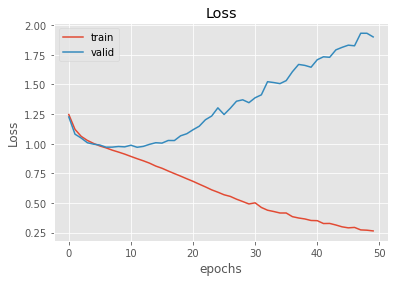

In [46]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

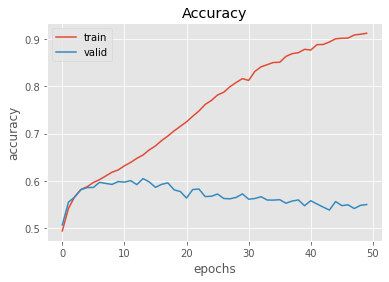

In [47]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();